In [1]:
# --- Cell 1: setup ---
from pathlib import Path
import sys, subprocess, os

DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)
OUT_DIR = Path("outputs/airline"); OUT_DIR.mkdir(parents=True, exist_ok=True)

def _pip(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for pkg in ["pandas>=2.0", "numpy", "matplotlib", "scikit-learn"]:
    try:
        __import__(pkg.split(">=")[0])
    except ImportError:
        _pip(pkg)

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression

print("Environment OK")


Environment OK


In [2]:
# --- Cell 2: load data with download + offline fallback ---
import io, requests, zipfile

def load_airline_sample():
    # Small public sample. If it fails, we synthesize.
    try:
        url = "https://people.sc.fsu.edu/~jburkardt/data/csv/airtravel.csv"
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        df = pd.read_csv(io.StringIO(r.text))
        # This file is monthly passengers by months. Not suitable. Use fallback immediately.
        raise RuntimeError("Sample file not suitable for delays. Using synthetic.")
    except Exception:
        # Synthetic but realistic schema similar to DOT On-Time Performance
        rng = np.random.default_rng(42)
        n = 50000  # large enough to look real, small enough to run fast
        carriers = ["AA","DL","UA","WN","B6","AS","NK","F9"]
        airports = ["ATL","DFW","DEN","ORD","LAX","CLT","MCO","LAS","PHX","SEA","MIA","EWR","SFO","JFK","BOS","IAD","DCA","SAN","BNA","TPA"]
        months = np.arange(1, 13)
        dow = np.arange(1, 8)

        df = pd.DataFrame({
            "carrier": rng.choice(carriers, size=n),
            "origin": rng.choice(airports, size=n),
            "dest": rng.choice(airports, size=n),
            "month": rng.choice(months, size=n, p=np.array([0.07,0.07,0.08,0.08,0.09,0.10,0.10,0.10,0.08,0.08,0.08,0.07])),
            "day_of_week": rng.choice(dow, size=n),
            "sched_dep_hour": rng.integers(5, 23, size=n),
            "distance_miles": rng.normal(900, 450, size=n).clip(150, 3000).round(),
        })

        # Latent factors: weather risk by month and airport, congestion by hour and hub status
        weather_month = {m: w for m, w in zip(months, np.linspace(0.6, 1.4, 12))}
        hubs = {"ATL","DFW","DEN","ORD","LAX","CLT","SEA","MIA","EWR","SFO","JFK"}
        hub_factor = df["origin"].isin(hubs).map({True:1.15, False:0.95})
        hour_factor = np.where(df["sched_dep_hour"].between(15,21), 1.25, 1.0)  # afternoon bank congestion

        base_delay_prob = 0.12
        prob = (
            base_delay_prob
            * df["month"].map(weather_month).values
            * hub_factor.values
            * hour_factor
            * np.where(df["distance_miles"] > 1500, 1.15, 1.0)
        )
        prob = np.clip(prob, 0.02, 0.65)
        df["delayed_15min"] = (rng.random(n) < prob).astype(int)

        # Create numeric targets
        dep_delay = rng.gamma(shape=2.0, scale=5.0, size=n)  # mostly small
        dep_delay *= (1 + 3*df["delayed_15min"])  # bigger if delayed flag
        dep_delay *= np.where(df["sched_dep_hour"].between(15,21), 1.15, 1.0)
        df["dep_delay_minutes"] = dep_delay.round(1)

        return df

air = load_airline_sample()
print(air.shape)
air.head()


(50000, 9)


,carrier,origin,dest,month,day_of_week,sched_dep_hour,distance_miles,delayed_15min,dep_delay_minutes
0,AA,DFW,BOS,12,5,11,1686.0,1,145.7
1,NK,TPA,SAN,4,3,20,534.0,0,23.1
2,AS,MIA,EWR,11,5,20,1048.0,0,13.0
3,WN,TPA,PHX,11,5,18,1236.0,0,12.0
4,WN,PHX,ATL,11,1,18,1312.0,1,21.6


In [3]:
# --- Cell 3: cleaning and feature engineering ---
df = air.copy()

# Remove impossible routes where origin == dest
df = df[df["origin"] != df["dest"]].copy()

# Cap extreme delays to reduce undue influence on plots
df["dep_delay_minutes"] = df["dep_delay_minutes"].clip(0, 300)

# Feature buckets
df["distance_bin"] = pd.cut(df["distance_miles"], bins=[0, 500, 1000, 1500, 2000, 10000],
                            labels=["<=500","501-1000","1001-1500","1501-2000",">2000"])
df["hour_bin"] = pd.cut(df["sched_dep_hour"], bins=[0,6,9,12,15,18,24],
                        labels=["0-5","6-8","9-11","12-14","15-17","18-23"])

print(df.isna().sum())
df.head()


carrier              0
origin               0
dest                 0
month                0
day_of_week          0
sched_dep_hour       0
distance_miles       0
delayed_15min        0
dep_delay_minutes    0
distance_bin         0
hour_bin             0
dtype: int64


,carrier,origin,dest,month,day_of_week,sched_dep_hour,distance_miles,delayed_15min,dep_delay_minutes,distance_bin,hour_bin
0,AA,DFW,BOS,12,5,11,1686.0,1,145.7,1501-2000,9-11
1,NK,TPA,SAN,4,3,20,534.0,0,23.1,501-1000,18-23
2,AS,MIA,EWR,11,5,20,1048.0,0,13.0,1001-1500,18-23
3,WN,TPA,PHX,11,5,18,1236.0,0,12.0,1001-1500,15-17
4,WN,PHX,ATL,11,1,18,1312.0,1,21.6,1001-1500,15-17


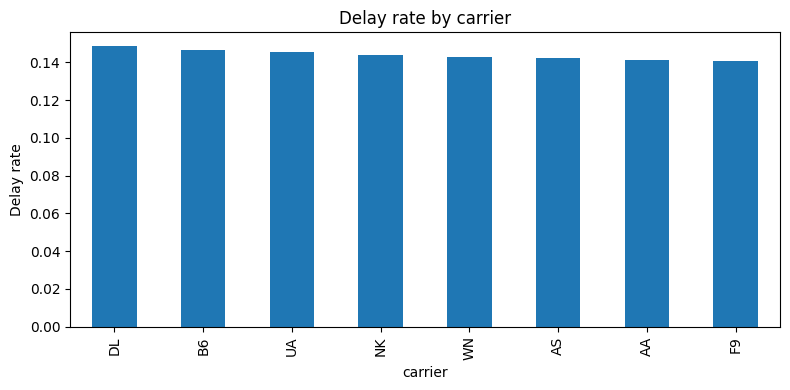

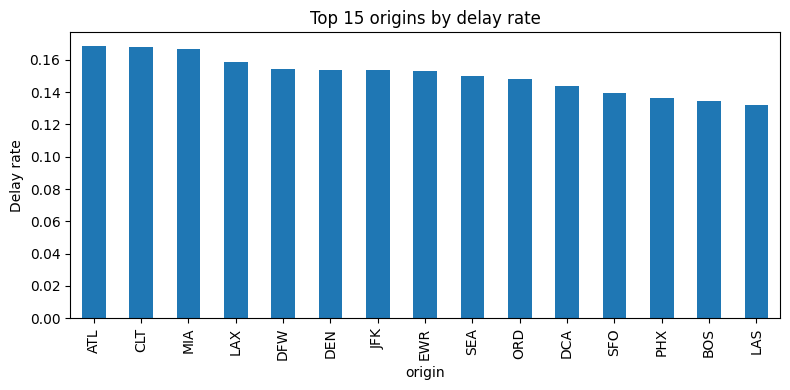

C:\Users\Owner\AppData\Local\Temp\ipykernel_2600\1214912948.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = pd.pivot_table(df, index="hour_bin", columns="carrier", values="delayed_15min", aggfunc="mean")


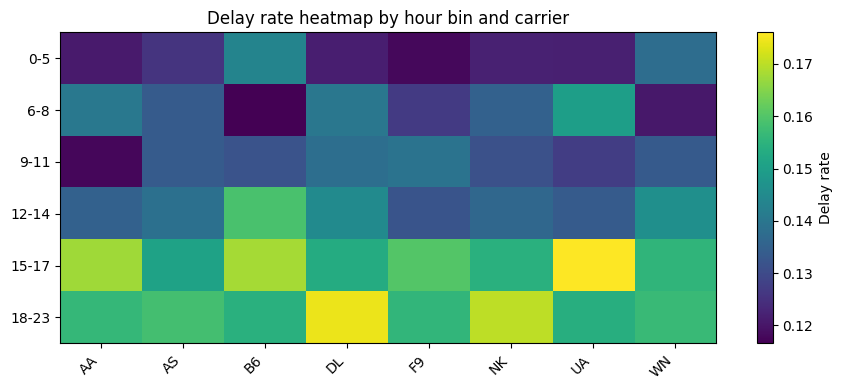

In [4]:
# --- Cell 4: EDA visuals ---
plt.figure(figsize=(8,4))
df.groupby("carrier")["delayed_15min"].mean().sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Delay rate")
plt.title("Delay rate by carrier")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
df.groupby("origin")["delayed_15min"].mean().sort_values(ascending=False)[:15].plot(kind="bar")
plt.ylabel("Delay rate")
plt.title("Top 15 origins by delay rate")
plt.tight_layout()
plt.show()

pivot = pd.pivot_table(df, index="hour_bin", columns="carrier", values="delayed_15min", aggfunc="mean")
plt.figure(figsize=(9,4))
plt.imshow(pivot.values, aspect="auto")
plt.xticks(range(pivot.shape[1]), pivot.columns, rotation=45, ha="right")
plt.yticks(range(pivot.shape[0]), pivot.index)
plt.colorbar(label="Delay rate")
plt.title("Delay rate heatmap by hour bin and carrier")
plt.tight_layout()
plt.show()


In [5]:
# --- Cell 5: model to predict 15+ minute delays ---
features = ["carrier","origin","dest","month","day_of_week","sched_dep_hour","distance_miles"]
target = "delayed_15min"

X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.25, random_state=1337, stratify=df[target]
)

cat_cols = ["carrier","origin","dest","month","day_of_week"]
num_cols = ["sched_dep_hour","distance_miles"]

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ("num", "passthrough", num_cols)
])

clf = Pipeline(steps=[
    ("pre", pre),
    ("lr", LogisticRegression(max_iter=1000, n_jobs=None))
])

clf.fit(X_train, y_train)
pred_proba = clf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, pred_proba)
print(f"ROC AUC: {auc:.3f}")

print(classification_report(y_test, (pred_proba>=0.5).astype(int), digits=3))


ROC AUC: 0.577
              precision    recall  f1-score   support

           0      0.856     1.000     0.922     10178
           1      0.000     0.000     0.000      1711

    accuracy                          0.856     11889
   macro avg      0.428     0.500     0.461     11889
weighted avg      0.733     0.856     0.790     11889



C:\Users\Owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

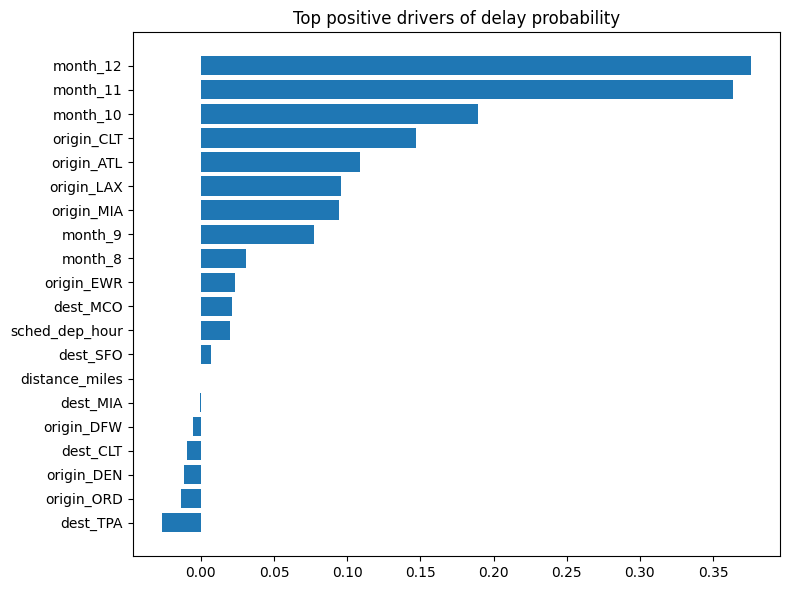

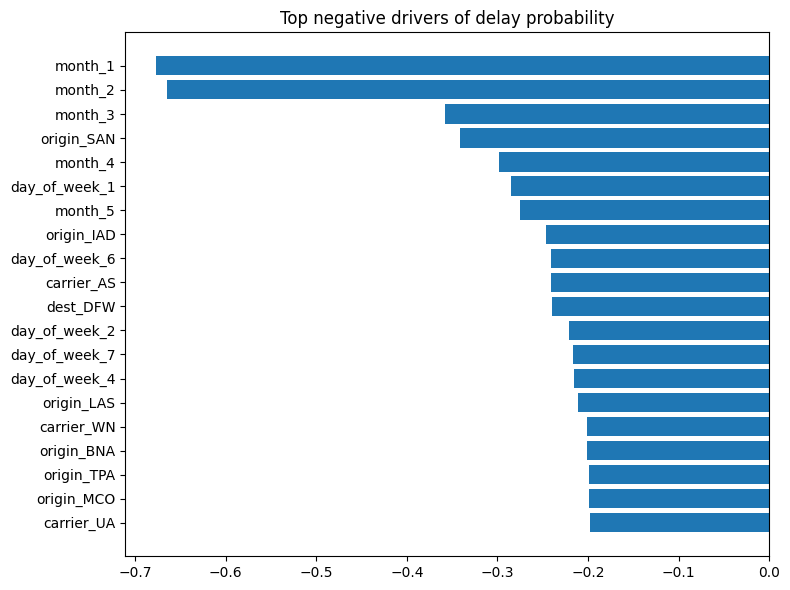

Wrote: C:\Users\Owner\outputs\airline\logreg_feature_coefs.csv


In [6]:
# --- Cell 6: model interpretability (top positive coefficients) ---
# Extract coefficient names
ohe = clf.named_steps["pre"].named_transformers_["cat"]
ohe_names = ohe.get_feature_names_out(cat_cols)
feature_names = list(ohe_names) + num_cols

coef = clf.named_steps["lr"].coef_[0]
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef}).sort_values("coef", ascending=False)

top_pos = coef_df.head(20)
top_neg = coef_df.tail(20)

plt.figure(figsize=(8,6))
plt.barh(top_pos["feature"][::-1], top_pos["coef"][::-1])
plt.title("Top positive drivers of delay probability")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.barh(top_neg["feature"], top_neg["coef"])
plt.title("Top negative drivers of delay probability")
plt.tight_layout()
plt.show()

OUT_DIR.mkdir(parents=True, exist_ok=True)
coef_df.to_csv(OUT_DIR / "logreg_feature_coefs.csv", index=False)
print("Wrote:", (OUT_DIR / "logreg_feature_coefs.csv").resolve())


In [7]:
# --- Cell 7: save tidy outputs for your repo ---
df.to_csv(OUT_DIR / "airline_delays_clean.csv", index=False)
summary_by_origin = df.groupby("origin", as_index=False).agg(
    flights=("delayed_15min", "size"),
    delay_rate=("delayed_15min", "mean"),
    avg_dep_delay=("dep_delay_minutes", "mean")
)
summary_by_origin.to_csv(OUT_DIR / "summary_by_origin.csv", index=False)
print("Wrote:", (OUT_DIR / "airline_delays_clean.csv").resolve())
print("Wrote:", (OUT_DIR / "summary_by_origin.csv").resolve())


Wrote: C:\Users\Owner\outputs\airline\airline_delays_clean.csv
Wrote: C:\Users\Owner\outputs\airline\summary_by_origin.csv
